In [ ]:
import jax.numpy as np
from jax import random, jit, vmap, jacfwd, grad
# from jax.experimental import optimizers
from jax.example_libraries import optimizers
from jax.nn import sigmoid, softplus
from jax import lax
# from jax.tree_util import tree_multimap, tree_reduce
from jax.tree_util import tree_map, tree_reduce
from jax.flatten_util import ravel_pytree

import itertools
from functools import partial
from torch.utils import data
from tqdm import trange
import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
! sudo apt-get install texlive-latex-recommended
! sudo apt install texlive-latex-extra
! sudo apt install dvipng
!apt install cm-super


plt.rcParams.update(plt.rcParamsDefault)
plt.rc('font', family='serif')
plt.rcParams.update({
                      "text.usetex": True,
                      "font.family": "serif",
                      'text.latex.preamble': r'\usepackage{amsmath}',
                      'font.size': 20,
                      'lines.linewidth': 3,
                      'axes.labelsize': 22,  # fontsize for x and y labels (was 10)
                      'axes.titlesize': 24,
                      'xtick.labelsize': 20,
                      'ytick.labelsize': 20,
                      'legend.fontsize': 20,
                      'axes.linewidth': 2})

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  dvisvgm fonts-droid-fallback fonts-lmodern fonts-noto-mono fonts-urw-base35
  libfontenc1 libgs9 libgs9-common libidn12 libijs-0.35 libjbig2dec0
  libkpathsea6 libptexenc1 libsynctex2 libteckit0 libtexlua53 libtexluajit2
  libwoff1 libzzip-0-13 lmodern poppler-data t1utils tex-common texlive-base
  texlive-binaries texlive-latex-base xfonts-encodings xfonts-utils
Suggested packages:
  fonts-noto fonts-freefont-otf | fonts-freefont-ttf fonts-texgyre
  poppler-utils ghostscript fonts-japanese-mincho | fonts-ipafont-mincho
  fonts-japanese-gothic | fonts-ipafont-gothic fonts-arphic-ukai
  fonts-arphic-uming fonts-nanum debhelper gv | postscript-viewer perl-tk xpdf
  | pdf-viewer xzdec texlive-latex-base-doc texlive-latex-recommended-doc
  texlive-luatex texlive-pstricks
The following NEW packages will be installed:
  dvisvgm fonts-droid-fa

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Helper function to compute dot products between PyTrees
def pytree_dot(x, y):
    # partial_dot = tree_multimap(lambda arr1, arr2: np.sum(arr1 * arr2), x, y)
    partial_dot = tree_map(lambda arr1, arr2: np.sum(arr1 * arr2), x, y)
    return tree_reduce(lax.add, partial_dot)


In [ ]:
def mFF_MLP_WN(layers, freqs, activation = np.tanh):
    ''' Multi-scale Fourier features MLP with weight normalization'''
    # Define input encoding function
    def input_encoding(x, w):
        out = np.hstack([np.sin(np.dot(x, w)),
                         np.cos(np.dot(x, w))])
        return out
    # Define linear layer
    def linear(x, w, b, g):
        v = w/np.linalg.norm(w, axis = 0, keepdims=True)
        return np.dot(x, v)*g + b
    # Initialize embedding weights (non-trainable)
    key, *keys = random.split(random.PRNGKey(0), len(freqs)+1)
    init_W = lambda key, freq: freq*random.normal(key, (layers[0], layers[1]//2))
    wFF = vmap(init_W)(*(np.array(keys), np.array(freqs)))
    # Define init function
    def init(rng_key):
        # Initialize neural net params
        def init_layer(key, d_in, d_out):
            k1, k2 = random.split(key)
            W = random.normal(k1, (d_in, d_out))
            b = np.zeros(d_out)
            g = np.ones(d_out)
            return W, b, g
        key, *keys = random.split(rng_key, len(layers))
        params = list(map(init_layer, keys, layers[1:-1], layers[2:]))
        return params
    # Define apply function
    def apply(params, inputs):
        H = vmap(input_encoding, in_axes=(None,0))(inputs, wFF)
        for W, b, g in params[:-1]:
            H = vmap(linear, in_axes=(0,None,None,None))(H, W, b, g)
            H = activation(H)
        W, b, g = params[-1]
        H = vmap(linear, in_axes=(0,None,None,None))(H, W, b, g)
        return H.flatten()
    return init, apply


In [ ]:
def weights_matrix(neig):
    vec = np.flip(20.0*(np.arange(neig)+1))
    mat = np.diag(vec)
    # mat = np.eye(neig)
    return mat

In [ ]:
class Sampler:
    # Initialize the class
    def __init__(self, dim, coords, name = None):
        self.dim = dim
        self.coords = coords
        self.name = name

    def sample(self, N, key = random.PRNGKey(1234)):
        x = self.coords.min(1) + (self.coords.max(1)-self.coords.min(1))*random.uniform(key, (N, self.dim))
        return x

In [ ]:
class DataGenerator(data.Dataset):
    def __init__(self, dom_sampler, batch_size=64):
        'Initialization'
        self.dom_sampler = dom_sampler
        self.batch_size = batch_size
        self.key = random.PRNGKey(1234)

    def __getitem__(self, index):
        'Generate one batch of data'
        self.key, subkey = random.split(self.key)
        X = self.__data_generation(subkey)
        return X

    @partial(jit, static_argnums=(0,))
    def __data_generation(self, key):
        'Generates data containing batch_size samples'
        inputs = self.dom_sampler.sample(self.batch_size, key)
        return inputs


In [ ]:
class SPIN:
    # Initialize the class
    def __init__(self, operator, layers, freqs):

        # Callable operator function
        self.operator = operator

        # Network initialization and evaluation functions
        self.net_init, self.net_apply = mFF_MLP_WN(layers, freqs)

        # Initialize network parameters
        params = self.net_init(random.PRNGKey(0))

        # Optimizer initialization and update functions
        lr = optimizers.exponential_decay(1e-3, decay_steps=1000, decay_rate=0.999)
        self.opt_init, \
        self.opt_update, \
        self.get_params = optimizers.rmsprop(lr)
        self.opt_state = self.opt_init(params)

        _, self.unravel_params = ravel_pytree(params)

        # Number of eigenvalues
        self.neig = len(freqs)

        # Logger
        self.itercount = itertools.count()
        self.loss_log = []
        self.evals_log = []
        self.weights_log = []

    def apply_mask(self, inputs, outputs):
        # mask is used to zero the boundary points.
        mask = 1.0
        if len(inputs.shape) == 2:
            for i in range(inputs.shape[1]):
                mask *= np.maximum((-inputs[:,i]**2 + np.pi * inputs[:,i]) , 0)
                # mask = -inputs[:,i]**2 + np.pi * inputs[:,i]
            mask = np.expand_dims(mask, -1)

        elif len(inputs.shape) == 1:
            for x in inputs:
                mask *= np.maximum((-x ** 2 + np.pi * x ), 0)
                # mask *= (-x ** 2 + np.pi * x)

        return mask*outputs

    def net_u(self, params, inputs):
        outputs = vmap(self.net_apply, in_axes=(None, 0))(params, inputs)
        outputs = self.apply_mask(inputs, outputs)
        return outputs

    def evaluate_spin(self, params, inputs):
        # Fetch batch
        n = inputs.shape[0]
        # Evaluate model
        u = self.net_u(params, inputs)
        sigma = np.dot(u.T, u)/n
        # Cholesky
        chol = np.linalg.cholesky(sigma)
        choli = np.linalg.inv(chol) # $L^{-1}$
        # Operator
        operator = self.operator(self.net_u, params, inputs)
        pi = np.dot(operator.T, u)/n # $\Pi$
        rq = np.dot(choli, np.dot(pi, choli.T)) # $\Lambda$
        return (u, choli, pi, rq, operator)

    def residuals(self, params, inputs):
        outputs = self.evaluate_spin(params, inputs)
        u, choli, _, rq, op = outputs
        dl = np.diag(np.diag(rq))
        residuals = np.dot(op, choli.T) - np.dot(np.dot(u, choli.T),dl)
        # residuals = rq - dl

        evals = np.diag(rq)
        loss_residual = np.mean(residuals**2, axis=0)
        # loss_trace = -1.0*evals
        weight_tr = weights_matrix(self.neig)
        evals = np.dot(weight_tr, evals)
        loss_trace = np.array([-1.0*np.sum(evals)])
        return np.hstack([loss_residual, loss_trace])

    @partial(jit, static_argnums=(0,))
    def loss(self, params, inputs, weights):
        losses = self.residuals(params, inputs)
        return np.dot(weights, losses)/self.neig

    # Define a jit-compiled update step
    @partial(jit, static_argnums=(0,))
    def step(self, i, opt_state, inputs, weights):
        params = self.get_params(opt_state)
        gradients = grad(self.loss)(params, inputs, weights)
        opt_state = self.opt_update(i, gradients, opt_state)
        return opt_state

    # Optimize parameters in a loop
    def train(self, dataset, nIter = 10000, ntk_weights = False):
        batch = iter(dataset)
        pbar = trange(nIter)
        # Initialize NTK weights
        if ntk_weights:
            params = self.get_params(self.opt_state)
            weights = self.update_NTK_weights(params, next(batch))
        else:
            weights = np.ones(1 + self.neig)
        # Main training loop
        for it in pbar:
            inputs = next(batch)
            # Run one gradient descent update
            self.opt_state = self.step(next(self.itercount),
                                       self.opt_state,
                                       inputs,
                                       weights)
            # Logger
            if it % 50 == 0:
                params = self.get_params(self.opt_state)
                losses = self.residuals(params, inputs)
                evals, _, _ = self.eigenpairs(params, inputs)
                self.loss_log.append(losses)
                self.evals_log.append(evals)
                # pbar.set_postfix({'Loss': np.sum(losses)/(2*self.neig)})
                pbar.set_postfix({'Loss': np.sum(losses)/(1 + self.neig)})
                if ntk_weights:
                    weights = self.update_NTK_weights(params, inputs)
                    self.weights_log.append(weights)


    # Evaluates predictions at test points
    @partial(jit, static_argnums=(0,))
    def eigenpairs(self, params, inputs):
        outputs = self.evaluate_spin(params, inputs)
        u, choli, _, rq, _ = outputs
        evals = np.diag(rq)
        efuns = np.matmul(u, choli.T)
        return evals, efuns, rq

    @partial(jit, static_argnums=(0,))
    def update_NTK_weights(self, params, inputs):
        def body_fn(i, state):
            r_fn = lambda theta: self.residuals(theta, inputs)[i]
            diag = grad(r_fn)(params)
            trace = pytree_dot(diag, diag)
            state = state.at[i].set(trace)
            return state
        # traces = lax.fori_loop(0, 2*self.neig, body_fn, np.zeros(2*self.neig))
        traces = lax.fori_loop(0, 1 + self.neig, body_fn, np.zeros(1 + self.neig))
        weights = np.sum(traces)/traces
        return weights**0.5
        # return weights

In [ ]:
def laplacian_1d(u_fn, params, inputs):
    def action(params, inputs):
        u_xx = jacfwd(jacfwd(u_fn, 1), 1)(params, inputs)
        return u_xx
    vec_fun = vmap(action, in_axes = (None, 0))
    laplacian = vec_fun(params, inputs)
    return np.squeeze(laplacian)


In [ ]:
# Exact solution in [0, pi]
def exact_eigenpairs_1d(x, n):
    idx = np.arange(n)+1
    evals = -idx**2
    efuns = np.sqrt(2.0/np.pi) * np.sin(idx * x)
    return evals, efuns

In [ ]:
# Problem setup
ndim = 1
neig = 25

# Domain boundaries
dom_coords = np.array([[0.0, np.pi]])

# Create data sampler
dom_sampler = Sampler(ndim, dom_coords)

dataset = DataGenerator(dom_sampler, batch_size = 256)

In [ ]:
# Test data
n_star = 1000
x_star = np.linspace(0.0, np.pi, n_star)[:,None]

In [ ]:
layers = [ndim, 256, 256, 1]
# layers = [ndim, 56, 128, 1]
alpha = 1.2
freqs = list(0.2*(np.arange(neig)+1)**alpha)
model = SPIN(laplacian_1d, layers, freqs)
print('Frequencies at initialization:\n{}'.format(freqs))

Frequencies at initialization:
[Array(0.2, dtype=float32, weak_type=True), Array(0.4594794, dtype=float32, weak_type=True), Array(0.7474386, dtype=float32, weak_type=True), Array(1.0556064, dtype=float32, weak_type=True), Array(1.3797297, dtype=float32, weak_type=True), Array(1.7171631, dtype=float32, weak_type=True), Array(2.0660827, dtype=float32, weak_type=True), Array(2.4251466, dtype=float32, weak_type=True), Array(2.7933223, dtype=float32, weak_type=True), Array(3.169787, dtype=float32, weak_type=True), Array(3.5538678, dtype=float32, weak_type=True), Array(3.9450047, dtype=float32, weak_type=True), Array(4.3427224, dtype=float32, weak_type=True), Array(4.746612, dtype=float32, weak_type=True), Array(5.1563163, dtype=float32, weak_type=True), Array(5.5715246, dtype=float32, weak_type=True), Array(5.991958, dtype=float32, weak_type=True), Array(6.41737, dtype=float32, weak_type=True), Array(6.8475366, dtype=float32, weak_type=True), Array(7.2822585, dtype=float32, weak_type=True),

In [ ]:
ntk_weights = True
model.train(dataset, nIter = 50000, ntk_weights = ntk_weights)

100%|██████████| 50000/50000 [07:11<00:00, 115.91it/s, Loss=34564.53]


In [ ]:
# Save model parameters
flat_params, _  = ravel_pytree(model.get_params(model.opt_state))
np.save('params_lapl_1d_new.npy', flat_params)

In [ ]:
# Restore parameters
# flat_params = np.load('params_lapl_1d.npy')
# !ls "/content/drive/My Drive"
# flat_params = np.load('/content/drive/My Drive/params_lapl_1d_new.npy')
opt_params = model.unravel_params(flat_params)

In [ ]:
# opt_params = model.get_params(model.opt_state)
evals, efuns, rq = model.eigenpairs(opt_params, x_star)
print('Predicted eigenvalues: {}'.format(evals))
evals_true, efuns_true = exact_eigenpairs_1d(x_star, neig)
print('True eigenvalues: {}'.format(evals_true))
# print("rq: {}".format(rq))
fig = plt.figure()
plt.imshow(rq)
plt.colorbar()
# fig.savefig("lapl_1d_rq" + ".pdf", bbox_inches='tight', dpi=600)

efuns_norm = efuns/np.sqrt(np.sum(efuns**2*np.pi/n_star, axis = 0))


Predicted eigenvalues: [  -1.0000001   -4.000123    -8.9999     -16.000069   -25.000113
  -36.000534   -64.00357    -49.00102   -100.003624  -121.008644
  -81.01224   -196.0202    -169.02275   -224.96246   -144.06024
 -324.025     -289.0535    -399.98218   -256.17413   -440.9856
 -361.03464   -528.99994   -484.19446   -576.30414   -625.3685   ]
True eigenvalues: [  -1   -4   -9  -16  -25  -36  -49  -64  -81 -100 -121 -144 -169 -196
 -225 -256 -289 -324 -361 -400 -441 -484 -529 -576 -625]


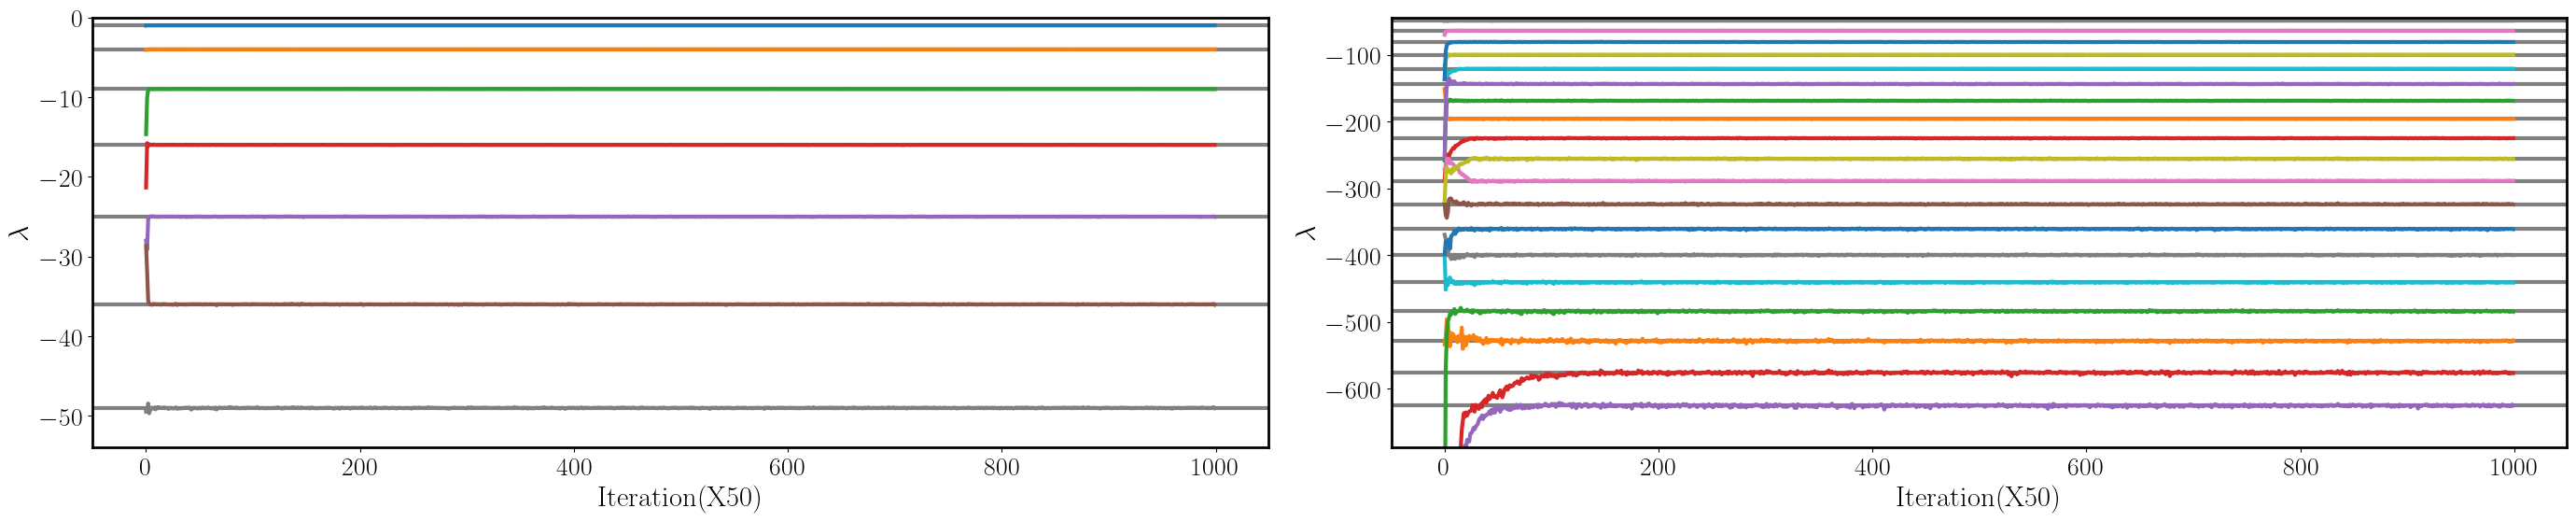

In [ ]:
fig = plt.figure(figsize = (28,6))
plt.subplot(1,2,1)
for i in range(neig):
    plt.axhline(evals_true[i], color='gray')
plt.plot(model.evals_log)
plt.xlabel('Iteration(X50)')
plt.ylabel('$\lambda$')
plt.ylim(evals_true[6]*1.1, 0)
plt.tight_layout()

plt.subplot(1,2,2)
for i in range(neig):
    plt.axhline(evals_true[i], color='gray')
plt.plot(model.evals_log)
plt.xlabel('Iteration(X50)')
plt.ylabel('$\lambda$')
plt.ylim(evals_true[-1]*1.1,evals_true[6]*0.9)


plt.tight_layout()

fig.savefig("lapl_1d_eigval_log" + ".pdf", bbox_inches='tight', dpi=600)
plt.show()

# colors = plt.cm.rainbow(np.linspace(0, 1, 2*neig))
# losses = np.array(model.loss_log)

# plt.figure(figsize = (20,4))
# plt.subplot(1,2,1)
# plt.plot(losses[:,:neig], 'b')
# plt.plot(losses[:,neig:], 'r')
# plt.yscale('log')
# plt.xlabel('Iteration (x50)')
# plt.ylabel('Loss')


# plt.subplot(1,2,2)
# if ntk_weights:
#     weights = np.array(model.weights_log)
# else:
#     weights = np.ones(neig)
# plt.plot(weights[:,neig:])
# plt.xlabel('Iteration (x50)')
# plt.ylabel('NTK weights')
# plt.yscale('log')
# plt.tight_layout()
# plt.show()



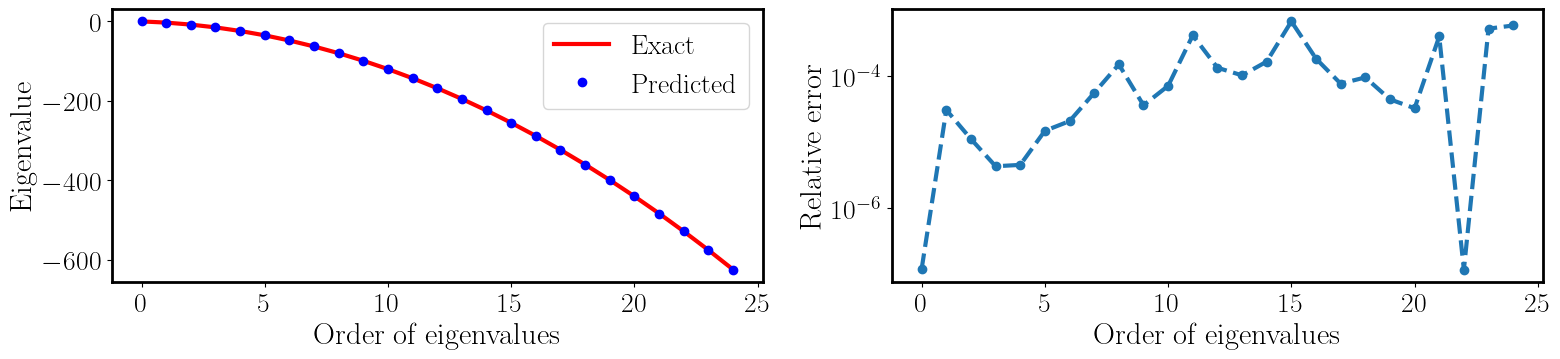

In [ ]:
fig = plt.figure(figsize = [16,4])

x = np.arange(25)
plt.subplot(1,2,1)
evals_ = np.flip(np.sort(evals))
plt.plot( x, evals_true,'r')
plt.plot(x, evals_,'b o')
plt.tight_layout()


plt.xlabel('Order of eigenvalues')
plt.ylabel('Eigenvalue')
plt.legend([ 'Exact ','Predicted'])

plt.subplot(1,2,2)
error = np.sqrt((evals_ - evals_true)**2/evals_true**2)
plt.plot(x, error,'--o')
plt.xlabel('Order of eigenvalues')
plt.ylabel('Relative error')
plt.yscale('log')
plt.tight_layout()

fig.savefig("lapl_1d_eig_error" + ".pdf", bbox_inches='tight', dpi=600)

plt.show()

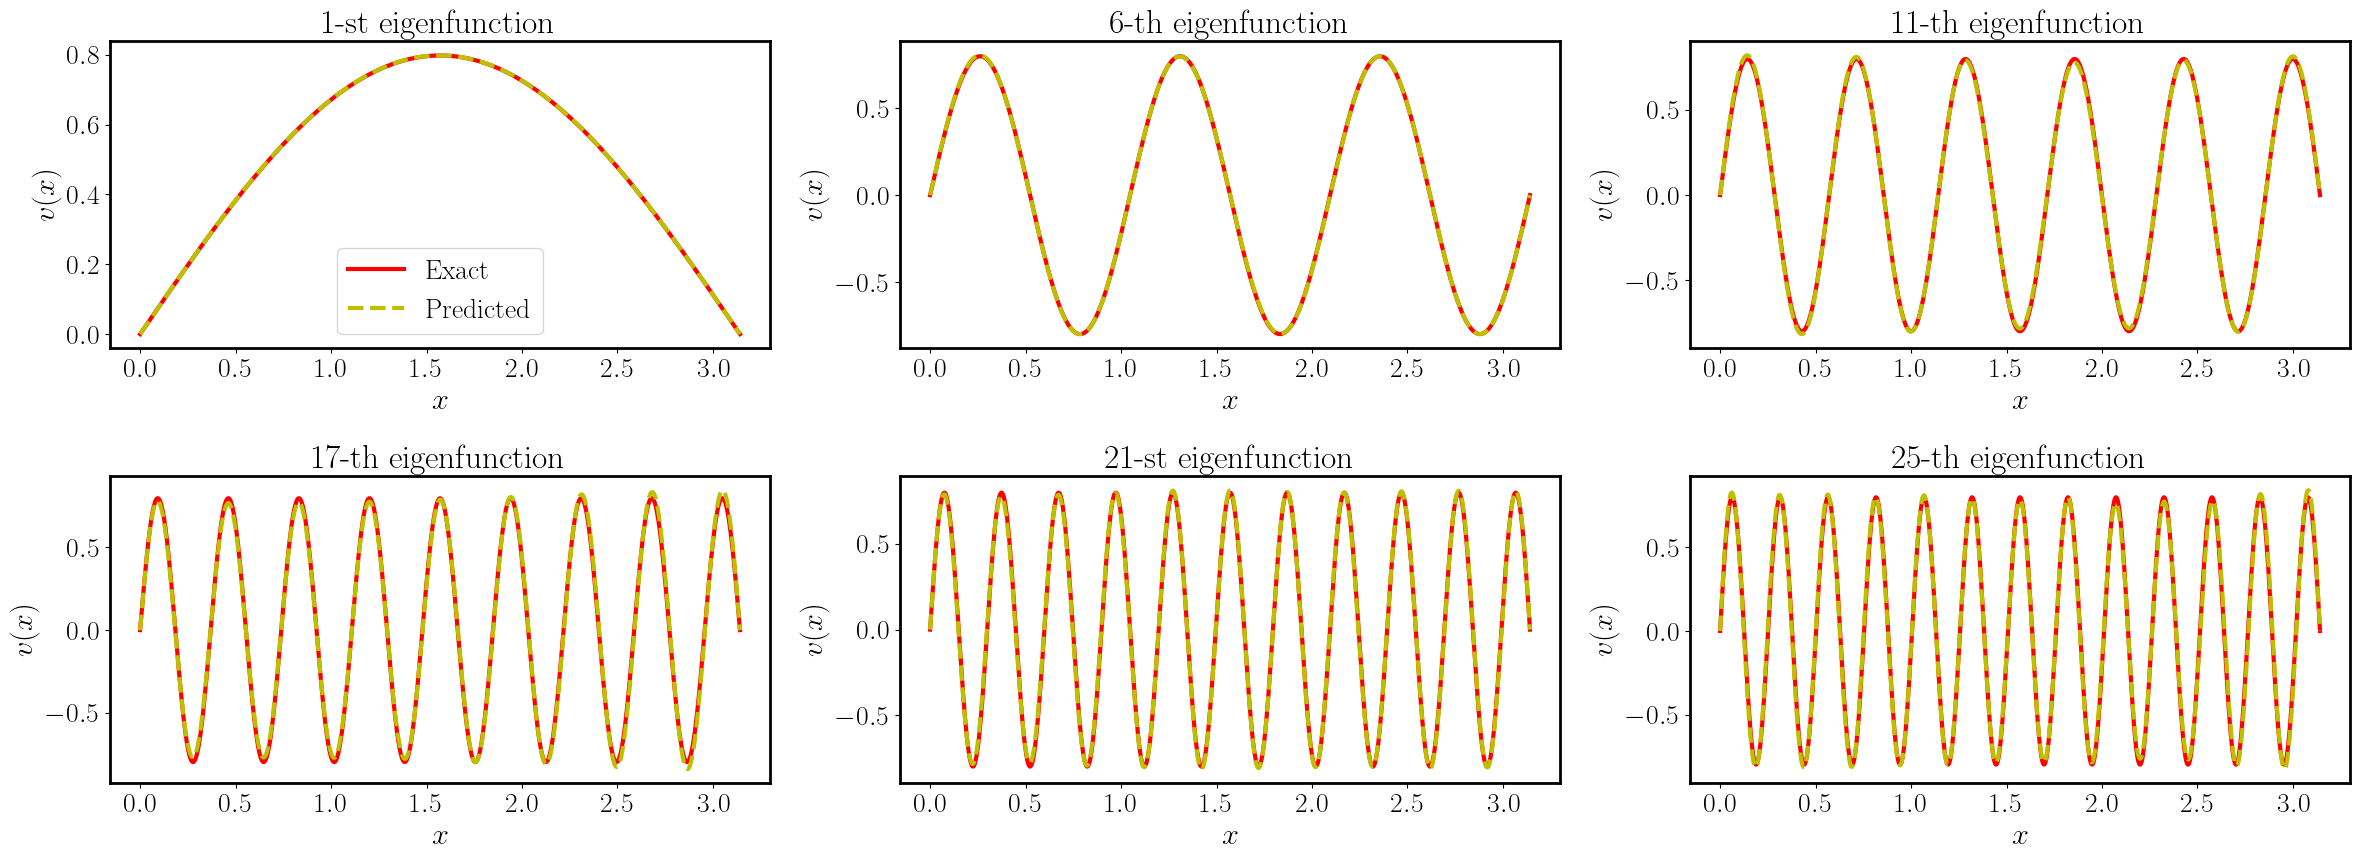

0.00055723026
0.004985175
0.01972345
0.038428623
0.02572299
0.045271285


In [ ]:
fig = plt.figure(figsize = [24,9])

plt.subplot(2,3,1)

plt.plot(x_star, np.sqrt(2.0/np.pi) * np.sin(1.0*x_star),'r')
plt.plot(x_star, -efuns_norm[:,0] ,'y--')
plt.xlabel('$x$')
plt.ylabel('$v(x)$')
plt.title('1-st eigenfunction')
plt.legend(['Exact','Predicted'])
u = np.sqrt(2.0/np.pi) * np.sin(1.0*x_star)
v = -efuns_norm[:,0][:,None]
error1 = np.linalg.norm(u-v, 2)/np.linalg.norm(u, 2)
plt.tight_layout()


plt.subplot(2,3,2)
plt.plot(x_star,np.sqrt(2.0/np.pi) * np.sin(6.0*x_star),'r')
plt.plot(x_star,efuns_norm[:,5] ,'y--',)
u = np.sqrt(2.0/np.pi) * np.sin(6.0*x_star)
v = efuns_norm[:,5][:,None]
error2 = np.linalg.norm(u-v, 2)/np.linalg.norm(u, 2)
plt.xlabel('$x$')
plt.ylabel('$v(x)$')
plt.title('6-th eigenfunction')
plt.tight_layout()



plt.subplot(2,3,3)
plt.plot(x_star,np.sqrt(2.0/np.pi) * np.sin(11.0*x_star),'r')
plt.plot(x_star, efuns_norm[:,9] ,'y--',)
u = np.sqrt(2.0/np.pi) * np.sin(11.0*x_star)
v = efuns_norm[:,9][:,None]
error3 = np.linalg.norm(u-v, 2)/np.linalg.norm(u, 2)
plt.xlabel('$x$')
plt.ylabel('$v(x)$')
plt.title('11-th eigenfunction')
plt.tight_layout()


plt.subplot(2,3,4)
plt.plot(x_star, np.sqrt(2.0/np.pi) * np.sin(17.0*x_star),'r')
plt.plot(x_star, -efuns_norm[:,16] ,'y--',)
u = np.sqrt(2.0/np.pi) * np.sin(17.0*x_star)
v = -efuns_norm[:,16][:,None]
error4 = np.linalg.norm(u-v, 2)/np.linalg.norm(u, 2)
plt.xlabel('$x$')
plt.ylabel('$v(x)$')
plt.title('17-th eigenfunction')
plt.tight_layout()


plt.subplot(2,3,5)
plt.plot(x_star,np.sqrt(2.0/np.pi) * np.sin(21.0*x_star),'r')
plt.plot(x_star, efuns_norm[:,19] ,'y--',)
u = np.sqrt(2.0/np.pi) * np.sin(21.0*x_star)
v = efuns_norm[:,19][:,None]
error5 = np.linalg.norm(u-v, 2)/np.linalg.norm(u, 2)
plt.xlabel('$x$')
plt.ylabel('$v(x)$')
plt.title('21-st eigenfunction')
plt.tight_layout()


plt.subplot(2,3,6)
plt.plot(x_star,np.sqrt(2.0/np.pi) * np.sin(25.0*x_star),'r')
plt.plot(x_star, efuns_norm[:,24] ,'y--',)
u = np.sqrt(2.0/np.pi) * np.sin(25.0*x_star)
v = efuns_norm[:,24][:,None]
error6 = np.linalg.norm(u-v, 2)/np.linalg.norm(u, 2)
plt.xlabel('$x$')
plt.ylabel('$v(x)$')
plt.title('25-th eigenfunction')

plt.tight_layout()

fig.savefig("lapl_1d_efuns" + ".pdf", bbox_inches='tight', dpi=600)

plt.show()

print(error1)
print(error2)
print(error3)
print(error4)
print(error5)
print(error6)

In [ ]:
def test_lapl_1d(u):
    def f(x):
        lapl = jacfwd(jacfwd(u))
        return -np.squeeze(vmap(lapl)(x))

    # Project f(x) onto the eigenbasis
    c = vmap(np.dot, in_axes=(None, 1))(f(x_star), efuns)/np.sum(efuns**2, axis = 0)

    # Compute solution
    w = -c/evals
    u_pred = np.sum(w*efuns,1,keepdims=True)


    # Exact solution and prediction error
    u_star = u(x_star)
    error = np.linalg.norm(u_star - u_pred, 2)/np.linalg.norm(u_star, 2)

    return u_star, error


<Figure size 640x480 with 0 Axes>

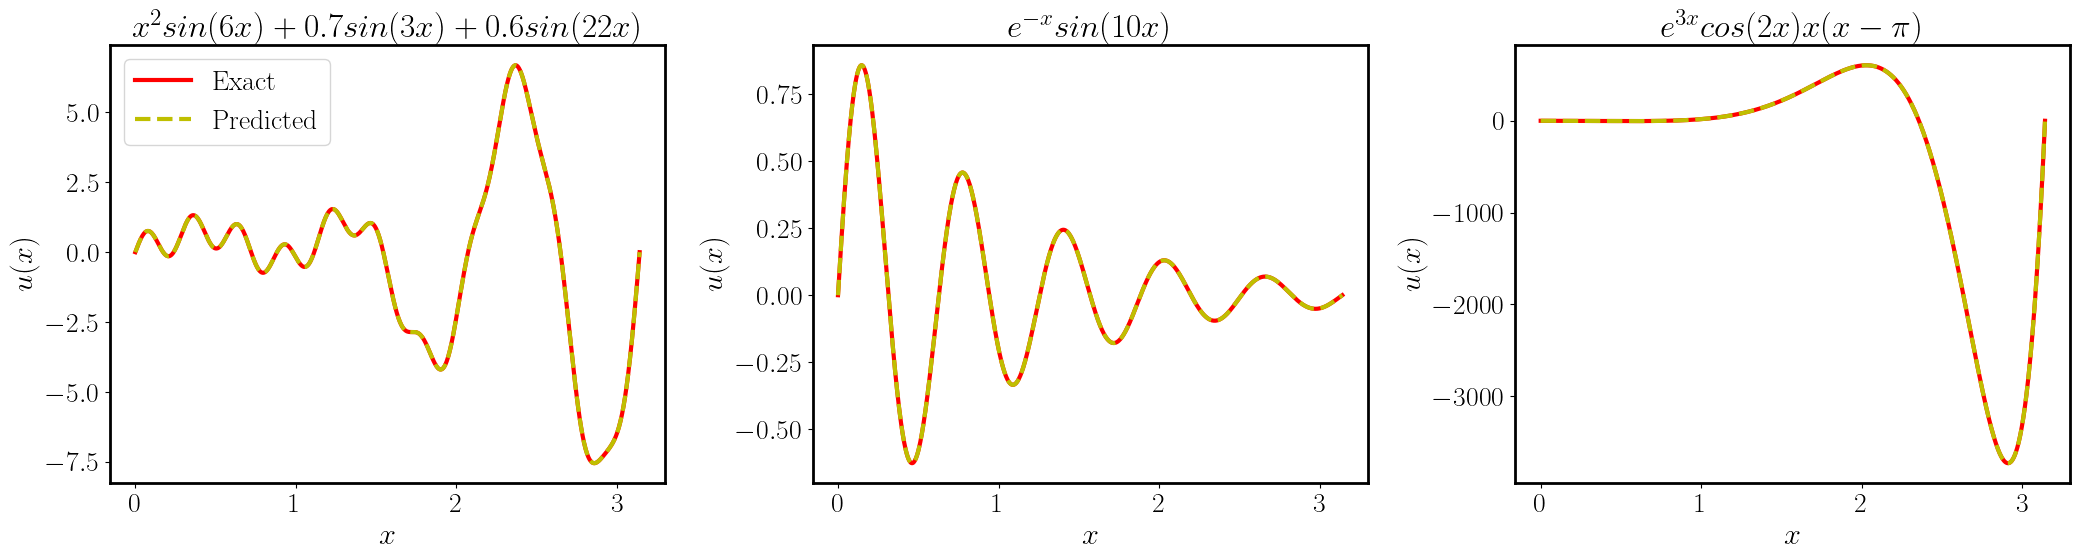

In [ ]:
fig = plt.figure(figsize = [21,6])

plt.subplot(1,3,1)
u1 = lambda x: x**2*np.sin(6.0*x) + 0.7*np.sin(3.0*x) + 0.6*np.sin(22.0*x)
u_star1, error1 = test_lapl_1d(u1)
u_pred1 = u1(x_star)
plt.plot(x_star, u_star1,'r')
plt.plot(x_star, u_pred1,'y--')
plt.xlabel('$x$')
plt.ylabel('$u(x)$')
plt.title('$x^2sin(6x) + 0.7sin(3x) + 0.6sin(22x)$')
plt.legend(['Exact','Predicted'])

plt.subplot(1,3,2)
u2 = lambda x: np.exp(-1.0*x)*np.sin(10.0*x)
u_star2, error2 = test_lapl_1d(u2)
u_pred2 = u2(x_star)
plt.plot(x_star, u_star2,'r')
plt.plot(x_star, u_pred2,'y--')
plt.xlabel('$x$')
plt.ylabel('$u(x)$')
plt.title('$e^{-x}sin(10x)$')


plt.subplot(1,3,3)
u3 = lambda x: np.exp(3.0*x)*np.cos(2.0*x)*x*(x-np.pi)
u_star3, error3 = test_lapl_1d(u3)
u_pred3 = u3(x_star)
plt.plot(x_star, u_star3, 'r')
plt.plot(x_star, u_pred3, 'y--')
plt.xlabel('$x$')
plt.ylabel('$u(x)$')
plt.title('$e^{3x}cos(2x)x(x-\pi)$')


plt.tight_layout()

fig.savefig("lapl_1d_nonhomo" + ".pdf", bbox_inches='tight', dpi=600)
plt.show()


In [ ]:
print(error1)
print(error2)
print(error3)

0.0039962092
0.010089276
0.013727503


In [ ]:
def test_heat_1d(a,t):
    def g(x):
        return np.sin(a*x)

    g_star = g(x_star)

    num = np.sum(efuns*efuns, axis = 0)
    c_init = np.dot(g_star.T, efuns)/num

    def u_heat(t):
        c_t = c_init * np.exp(evals*t/a**2)
        u = np.dot(efuns, c_t.T)
        return u

    u_pred = u_heat(t)

    def u_exact(x,t):
        u = np.exp(-1.0*t)*np.sin(a*x)
        return u

    u_star = u_exact(x_star, t)
    # plt.plot(x_star, u_pred )
    # plt.plot(x_star, u_star)

    error = np.linalg.norm(u_star - u_pred, 2)/np.linalg.norm(u_star, 2)
    # print("error is: {}".format(error))
    return u_pred, u_star, error

In [ ]:
tt = np.linspace(0,1.0,100)
u_pred_all = np.zeros([ x_star.shape[0],tt.shape[0]])
u_star_all = u_pred_all
# errors =  u_pred_all

grid = np.meshgrid(np.squeeze(x_star), tt)
coords = np.array(grid).T.reshape(-1,2)

for i in range(tt.shape[0]):
    u_pred,u_star ,_ = jit(test_heat_1d)(4.0,tt[i])
    u_pred_all = u_pred_all.at[:,i].set(np.squeeze(u_pred))
    u_star_all = u_star_all.at[:,i].set(np.squeeze(u_star))
    # errors = errors.at[:,i].set(np.squeeze(error))
u_pred_all1 = u_pred_all.reshape(-1,1)
u_star_all1 = np.squeeze(u_star_all.reshape(-1,1))
# errors1 = np.squeeze(errors.reshape(-1,1))
# errors = abs(u_star_all - u_pred_all)/(abs(u_star_all)+1e-8)
errors = abs(u_star_all - u_pred_all)
errors = np.squeeze(errors.reshape(-1,1))

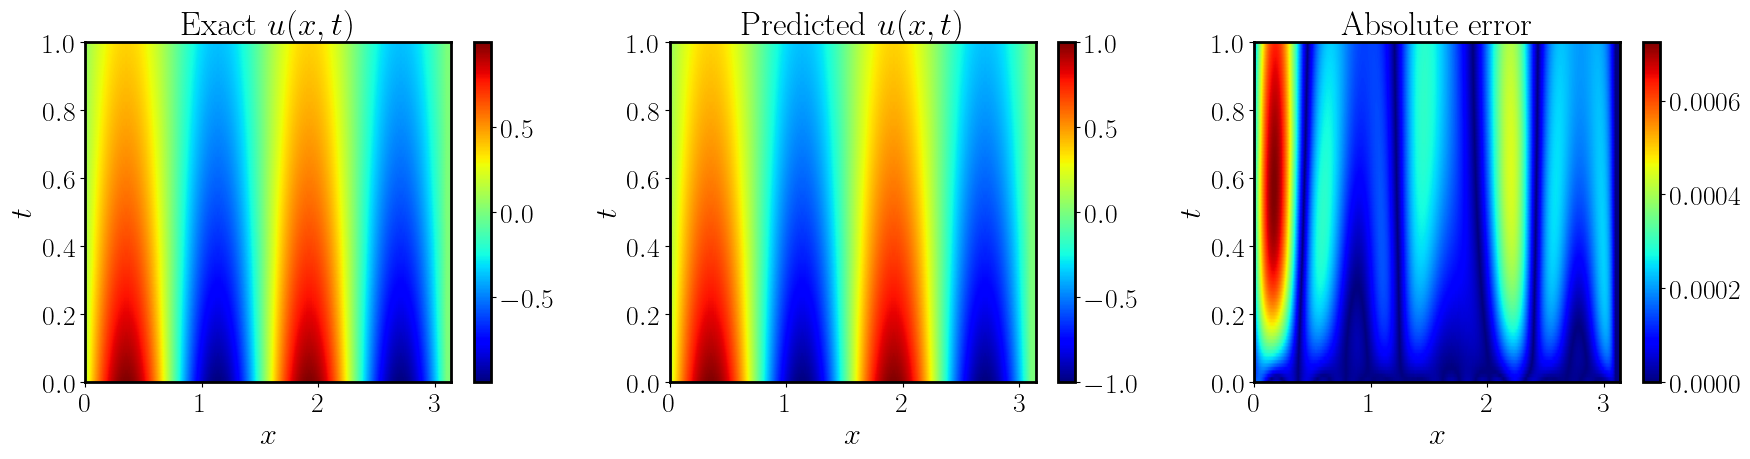

In [ ]:
fig = plt.figure(figsize = [18,5])
plt.subplot(1,3,1)
plt.scatter(coords[:,0],coords[:,1],c = u_star_all1, cmap = 'jet')
plt.ylim([0.0,1.0])
plt.xlim([0.0,np.pi])
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.title('Exact $u(x,t)$')
plt.colorbar()


plt.subplot(1,3,2)
plt.scatter(coords[:,0],coords[:,1],c = u_pred_all1, cmap = 'jet')
plt.ylim([0.0,1.0])
plt.xlim([0.0,np.pi])
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.title('Predicted $u(x,t)$')
plt.colorbar()

plt.subplot(1,3,3)
plt.scatter(coords[:,0],coords[:,1],c = errors, cmap = 'jet')
plt.ylim([0.0,1.0])
plt.xlim([0.0,np.pi])
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.title('Absolute error')
plt.colorbar()

plt.tight_layout()


fig.savefig("lapl_1d_heat_eqn" + ".pdf", bbox_inches='tight', dpi=600)
# plt.figure()
# plt.plot(x_star, u_pred_all[:,-1])
plt.show()

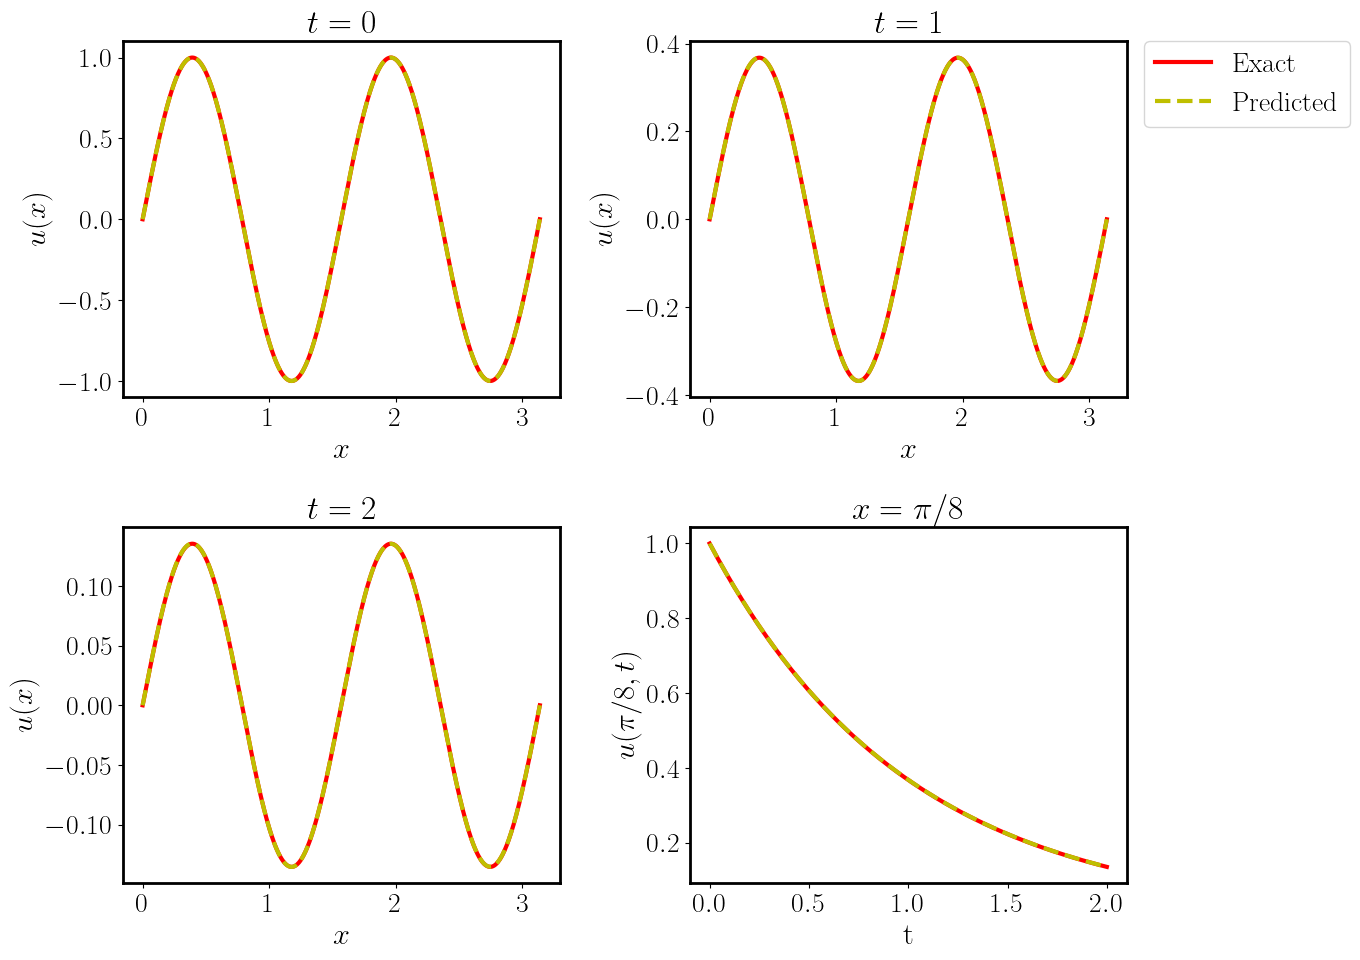

In [ ]:
fig = plt.figure(figsize = [14,10])

plt.subplot(2,2,1)
u_pred1, u_star1, error1 = test_heat_1d(4,0)
plt.plot(x_star,u_star1,'r')
plt.plot(x_star, u_pred1,'y--')
plt.xlabel('$x$')
plt.ylabel('$u(x)$')
plt.title('$t = 0$')

plt.tight_layout()

plt.subplot(2,2,2)
u_pred2, u_star2, error2 = test_heat_1d(4,1)
plt.plot(x_star,u_star2,'r')
plt.plot(x_star, u_pred2,'y--')
plt.xlabel('$x$')
plt.ylabel('$u(x)$')
plt.title('$t = 1$')
plt.legend(['Exact',' Predicted '],bbox_to_anchor=(1.04,1), borderaxespad=0)



plt.tight_layout()

plt.subplot(2,2,3)
u_pred3, u_star3, error3 = test_heat_1d(4,2)
plt.plot(x_star,u_star3,'r')
plt.plot(x_star, u_pred3,'y--')
plt.xlabel('$x$')
plt.ylabel('$u(x)$')
plt.title('$t = 2$')

plt.tight_layout()

plt.subplot(2,2,4)
t_space = np.linspace(0.0,2.0,50)
u_pred_t1 = np.zeros(len(t_space))
u_real_t1 = u_pred_t1
u_pred_t2 = u_pred_t1
u_real_t2 = u_pred_t1
for i in np.arange(len(t_space)) :
    t = t_space[i]
    u_pred, u_star,_ = test_heat_1d(4,t)
    u_pred_t1 = u_pred_t1.at[i].set(u_pred[125,0])
    u_real_t1 = u_real_t1.at[i].set(u_star[125,0])
    # u_pred_t2 = u_pred_t2.at[i].set(u_pred[375,0])
    # u_real_t2 = u_real_t2.at[i].set(u_star[375,0])
plt.plot(t_space, u_real_t1, 'r')
plt.plot(t_space, u_pred_t1, 'y--')
# plt.plot(t_space, u_real_t2)
# plt.plot(t_space, u_pred_t2, '--')
plt.xlabel('t')
plt.ylabel('$u(\pi/8, t)$')
plt.title('$x = \pi/8$')




plt.tight_layout()
plt.show()
fig.savefig("lapl_1d_heat_eqn" + ".pdf", bbox_inches='tight', dpi=600)

In [ ]:
print(error1)
print(error2)
print(error3)

0.0039962092
0.010089276
0.013727503


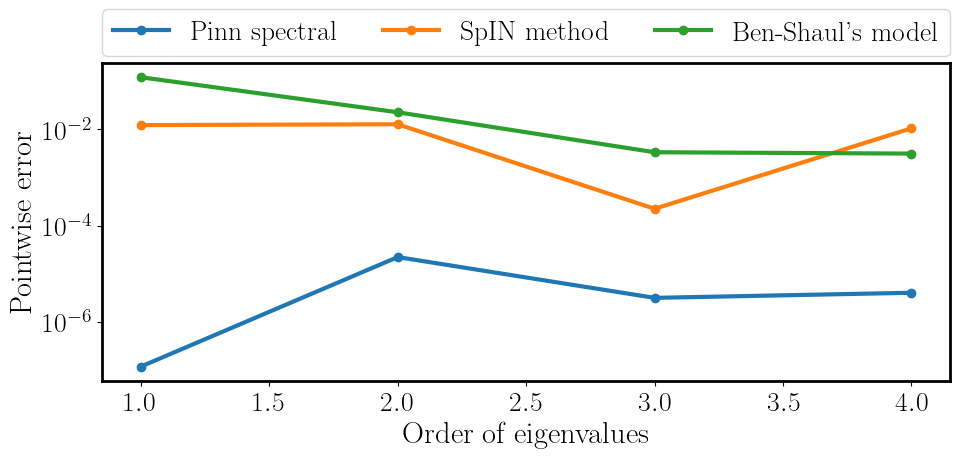

In [ ]:

x = np.arange(4)+1
y = np.array([-1.0, -4.0, -9.0, -16.0])
y1 = np.array([-1.0000001 ,  -4.000089 ,   -8.999971  , -16.000065  ])
error1 = np.sqrt((y-y1)**2/y**2)

y2 = np.array([-1.0121921  ,-4.0507536  ,-8.997984 , -16.167412])
error2 = np.sqrt((y-y2)**2/y**2)
y3 = np.array([-1.12, -4.09, -9.03, -15.95])
error3 = np.sqrt((y-y3)**2/y**2)

fig = plt.figure(figsize = (10,5))
plt.plot(x,error1,'-o', x, error2,'-o', x, error3,'-o')
plt.yscale('log')
plt.legend(['Pinn spectral','SpIN method', 'Ben-Shaul’s model'],bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=3)
plt.xlabel('Order of eigenvalues')
plt.ylabel('Pointwise error')

plt.tight_layout()

fig.savefig("lapl_1d_error" + ".pdf", bbox_inches='tight', dpi=600)
plt.show()

In [ ]:
errors = np.zeros(25)
for i in np.arange(25):
    u1 = lambda x: np.sin((i+1.0)*x)
    _, error = test_lapl_1d(u1)
    errors = errors.at[i].set(error)
print(errors)

[0.00018468 0.00278671 0.00598302 0.00088383 0.00356164 0.00325711
 0.0038141  0.00435725 0.00703382 0.00587458 0.00790795 0.01087841
 0.00732355 0.00660196 0.01546709 0.01156108 0.00820921 0.01321682
 0.01047756 0.01337314 0.01190995 0.01583845 0.01459364 0.02773995
 0.04414272]
